Using device: cuda
Filtered Data Count (Difficulty>=15): 81
Train Size: 64
Validation Size: 17
Epoch 1/46


Train Loss: 0.4470


Validation Loss: 0.4484
Saved Best Model
Epoch 2/46


Train Loss: 0.4386


Validation Loss: 0.4445
Saved Best Model
Epoch 3/46


Train Loss: 0.4395


Validation Loss: 0.4488
Epoch 4/46


Train Loss: 0.4411


Validation Loss: 0.4483
Epoch 5/46


Train Loss: 0.4363


Validation Loss: 0.4467
Epoch 6/46


Train Loss: 0.4359


Validation Loss: 0.4443
Saved Best Model
Epoch 7/46


Train Loss: 0.4333


Validation Loss: 0.4451
Epoch 8/46


Train Loss: 0.4328


Validation Loss: 0.4447
Epoch 9/46


Train Loss: 0.4313


Validation Loss: 0.4483
Epoch 10/46


Train Loss: 0.4323


Validation Loss: 0.4522
Epoch 11/46


Train Loss: 0.4310


Validation Loss: 0.4506
Epoch 12/46


Train Loss: 0.4286


Validation Loss: 0.4515
Epoch 13/46


Train Loss: 0.4289


Validation Loss: 0.4507
Epoch 14/46


Train Loss: 0.4271


Validation Loss: 0.4556
Epoch 15/46


Train Loss: 0.4246


Validation Loss: 0.4461
Epoch 16/46


Train Loss: 0.4222


Validation Loss: 0.4553
Epoch 17/46


Train Loss: 0.4226


Validation Loss: 0.4574
Epoch 18/46


Train Loss: 0.4191


Validation Loss: 0.4520
Epoch 19/46


Train Loss: 0.4226


Validation Loss: 0.4554
Epoch 20/46


Train Loss: 0.4125


Validation Loss: 0.4579
Epoch 21/46


Train Loss: 0.4097


Validation Loss: 0.4787
Epoch 22/46


Train Loss: 0.4107


Validation Loss: 0.4656
Epoch 23/46


Train Loss: 0.4061


Validation Loss: 0.4626
Epoch 24/46


Train Loss: 0.4028


Validation Loss: 0.4677
Epoch 25/46


Train Loss: 0.3973


Validation Loss: 0.4799
Epoch 26/46


Train Loss: 0.3951


Validation Loss: 0.4696
Epoch 27/46


Train Loss: 0.3920


Validation Loss: 0.4725
Epoch 28/46


Train Loss: 0.3869


Validation Loss: 0.4739
Epoch 29/46


Train Loss: 0.3843


Validation Loss: 0.4733
Epoch 30/46


Train Loss: 0.3779


Validation Loss: 0.4995
Epoch 31/46


Train Loss: 0.3760


Validation Loss: 0.4732
Epoch 32/46


Train Loss: 0.3720


Validation Loss: 0.4732
Epoch 33/46


Train Loss: 0.3719


Validation Loss: 0.4922
Epoch 34/46


Train Loss: 0.3674


Validation Loss: 0.4897
Epoch 35/46


Train Loss: 0.3657


Validation Loss: 0.4929
Epoch 36/46


Train Loss: 0.3554


Validation Loss: 0.4976
Epoch 37/46


Train Loss: 0.3529


Validation Loss: 0.5051
Epoch 38/46


Train Loss: 0.3512


Validation Loss: 0.4906
Epoch 39/46


Train Loss: 0.3494


Validation Loss: 0.5069
Epoch 40/46


Train Loss: 0.3437


Validation Loss: 0.5255
Epoch 41/46


Train Loss: 0.3420


Validation Loss: 0.5236
Epoch 42/46


Train Loss: 0.3366


Validation Loss: 0.5258
Epoch 43/46


Train Loss: 0.3386


Validation Loss: 0.5206
Epoch 44/46


Train Loss: 0.3325


Validation Loss: 0.5278
Epoch 45/46


Train Loss: 0.3287


Validation Loss: 0.5293
Epoch 46/46


Train Loss: 0.3233


/tmp/ipykernel_3223977/1848582650.py:729: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("best_presence_only_transformer_model.pth"))


Validation Loss: 0.5329


Difficulty 15: Accuracy=0.8476, Precision=1.0000, Recall=0.0011, F1 Score=0.0022
Difficulty 16: Accuracy=0.8155, Precision=0.0000, Recall=0.0000, F1 Score=0.0000


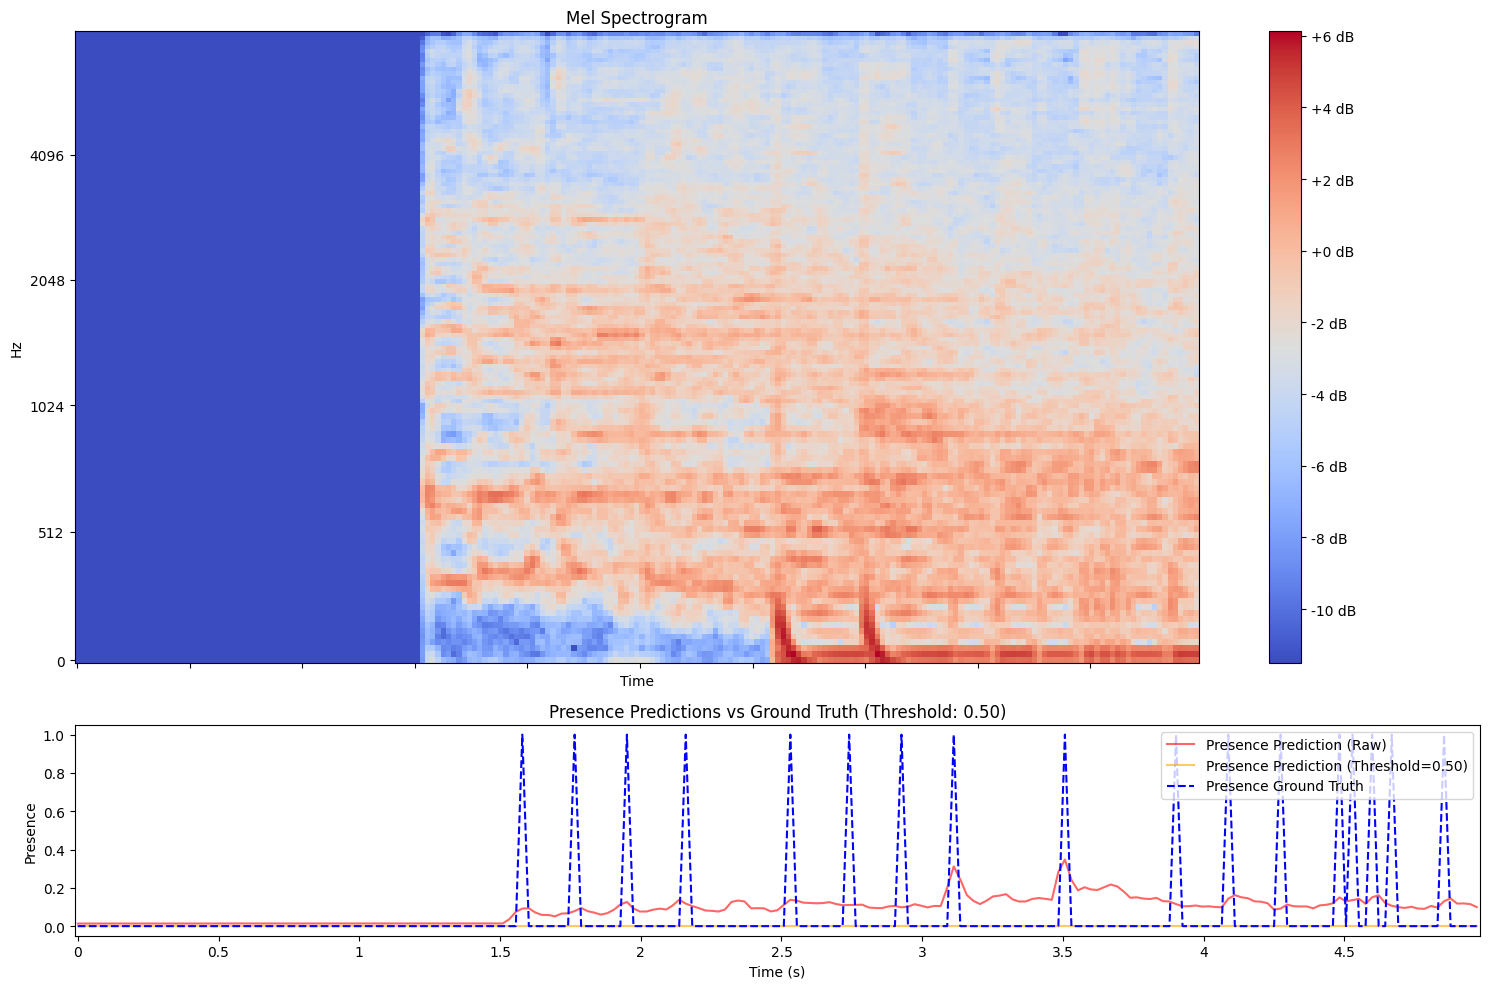

In [ ]:
# Cytoid-AI-charting without Threshold Prediction

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, random_split
from torch.nn.utils.rnn import pad_sequence
from pathlib import Path
import json
import librosa
import librosa.display
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict
from typing import List, Tuple, Dict, Any
import enum
import tqdm
import pickle  # If future model saving is needed, can use
from sklearn.metrics import f1_score, recall_score, accuracy_score, precision_score

# STFT Constants
SAMPLE_RATE = 22050  
HOP_LENGTH = 512     
NMELS = 128        
FRAME = 20     

# Check GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

def contains_non_ascii(s: str) -> bool:
    """Check if the string contains non-ASCII characters."""
    return any(ord(c) > 127 for c in s)

def extract_level_json(directory: Path, min_difficulty: int = 15) -> Dict[str, Any]:
    """
    Extract level.json files from the directory, organize relevant information, and filter out songs with specified difficulty.

    Args:
        directory (Path): The main directory containing subfolders.
        min_difficulty (int): The minimum difficulty level.

    Returns:
        Dict[str, Any]: Contains relevant information for each level, limited to songs with difficulty >= min_difficulty.
    """
    result = {}
    
    for folder_path in directory.iterdir():
        if not folder_path.is_dir():
            continue
        json_file_path = folder_path / 'level.json'
        if json_file_path.is_file():
            with json_file_path.open('r', encoding='utf-8') as json_file:
                try:
                    level_data = json.load(json_file)
                except json.JSONDecodeError:
                    print(f"JSON decode error for file: {json_file_path}")
                    continue

            chart_difficulty = level_data['charts'][0].get('difficulty', 0)
            # Filter songs with difficulty >= min_difficulty
            if chart_difficulty < min_difficulty:
                continue

            # Extract audio file and chart file paths
            audio_file_name = level_data['music']['path']
            audio_file_extensions = ['.mp3', '.ogg', '.wav']
            audio_file_path = None

            for ext in audio_file_extensions:
                aud_path = folder_path / audio_file_name
                if aud_path.suffix.lower() == ext and aud_path.is_file():
                    audio_file_path = aud_path
                    break
            if audio_file_path is None:
                continue  

            charts_path = folder_path / level_data['charts'][0]['path']
            if not charts_path.is_file():
                continue

            result[level_data['id']] = {
                'level': level_data,
                'mp3_path': str(audio_file_path),
                'charts_path': str(charts_path),
                'charter': level_data.get('charter', ''),
                'type': level_data['charts'][0].get('type', ''),
                'difficulty': chart_difficulty
            }
    return result

def extract_charts(path: str) -> Dict[str, Any]:
    """
    Extract chart data from a JSON file.

    Args:
        path (str): The path to the chart JSON file.

    Returns:
        Dict[str, Any]: Chart data.
    """
    file_path = Path(path)
    if file_path.exists() and file_path.is_file():
        with open(file_path, 'r', encoding='utf-8') as f:
            try:
                data = json.load(f)
                return data
            except json.JSONDecodeError:
                print(f"JSON decode error for file: {path}")
    return {}

def find_single_tempo_songs(data: Dict[str, Any]) -> List[Dict[str, Any]]:
    """
    Filter songs with a constant BPM.

    Args:
        data (Dict[str, Any]): A dictionary containing all song information.

    Returns:
        List[Dict[str, Any]]: A list of songs with constant BPM.
    """
    single_tempo_songs = []
    for song_id, song in data.items():
        charts_data = extract_charts(song['charts_path'])
        if charts_data and 'tempo_list' in charts_data:
            if len(charts_data['tempo_list']) == 1:
                single_tempo_songs.append(song)
    return single_tempo_songs

def map_note_to_time(data: Dict[str, Any]) -> List[Dict[str, Any]]:
    """
    Map notes to time.

    Args:
        data (Dict[str, Any]): Chart data.

    Returns:
        List[Dict[str, Any]]: Time mapping information for each note.
    """
    time_base = data.get('time_base', 1000) 
    offset_universal = 0.033 
    offset = data.get('music_offset', 0) - offset_universal
    tempo_list = sorted(data.get('tempo_list', []), key=lambda x: x['tick'])  
    note_list = data.get('note_list', [])
    
    note_time_map = []
    accumulated_time = 0 
    last_tick = 0  
    if not tempo_list:
        return note_time_map
    current_tempo = tempo_list[0]['value']  
    tempo_index = 0  

    for note in note_list:
        note_tick = note['tick']
        while tempo_index < len(tempo_list) - 1 and tempo_list[tempo_index + 1]['tick'] <= note_tick:
            next_tempo_tick = tempo_list[tempo_index + 1]['tick']
            ticks_in_interval = next_tempo_tick - last_tick
            tick_duration = (current_tempo / time_base) 
            accumulated_time += ticks_in_interval * tick_duration
            last_tick = next_tempo_tick
            tempo_index += 1
            current_tempo = tempo_list[tempo_index]['value']

        ticks_in_interval = note_tick - last_tick
        tick_duration = (current_tempo / time_base) 
        note_time = accumulated_time + ticks_in_interval * tick_duration
        note_time_map.append({
            'note_id': note.get('id', 0),
            'note_tick': note_tick,
            'note_time_microseconds': note_time - offset * 1_000_000,
            'note_type': note.get('type', 0),
            'note_x': note.get('x', 0.0)
        })

    return note_time_map

def generate_mel_spectrogram(
    audio_path: Path,
    log_enable: bool = True,
    bpm_info: List[Dict[str, float]] = None,
    note_info: List[Dict[str, Any]] = None,
    max_frames: int = 5000  # New parameter to limit maximum frames
) -> dict:
    """
    Generate Mel spectrogram and corresponding labels, limiting its length to max_frames.

    Args:
        audio_path (Path): Path to the audio file.
        log_enable (bool): Whether to apply logarithmic transformation.
        bpm_info (List[Dict[str, float]]): BPM information.
        note_info (List[Dict[str, Any]]): Note information.
        max_frames (int): Maximum number of frames.

    Returns:
        dict: A dictionary containing the Mel spectrogram and labels.
    """
    data, sr = librosa.load(str(audio_path), sr=SAMPLE_RATE)
    assert sr == SAMPLE_RATE, f"Expected sample rate {SAMPLE_RATE}, but got {sr}"

    mel = librosa.feature.melspectrogram(
        y=data,
        sr=sr, 
        hop_length=HOP_LENGTH, 
        fmin=30.0, 
        n_mels=NMELS, 
        htk=True
    )
    if log_enable:
        mel = np.log(np.clip(mel, 1e-5, None))
    mel = mel.T  # (time steps, features)

    # Limit the length of the Mel spectrogram
    if mel.shape[0] > max_frames:
        mel = mel[:max_frames]
    
    data_dic = {"mel": mel}

    if bpm_info and note_info:
        mel_length = mel.shape[0]
        labels = np.zeros((mel_length, 1))  # Only [presence]
        for note in note_info:
            time_sec = note['note_time_microseconds'] / 1_000_000
            frame_idx = int(time_sec * SAMPLE_RATE / HOP_LENGTH)
            if frame_idx < mel_length:
                labels[frame_idx, 0] = 1  # Presence
        data_dic["labels"] = labels  # shape: (mel_length, 1)

    return data_dic

class TimeUnit(enum.Enum):
    milliseconds = "milliseconds"
    frames = "frames"
    seconds = "seconds"

class OnsetDataset(Dataset):
    """
    PyTorch Dataset class for loading and providing data.
    """
    def __init__(self, data: Dict[str, Any], bpm_info: Dict[str, List[Dict[str, float]]], score_positions: Dict[str, List[Dict[str, Any]]], transform=None):
        self.data = data
        self.bpm_info = bpm_info
        self.score_positions = score_positions
        self.transform = transform
        self.samples = self.prepare_samples()
        
    def prepare_samples(self) -> List[Tuple[np.ndarray, np.ndarray, int]]:
        """
        Prepare data samples.

        Returns:
            List[Tuple[np.ndarray, np.ndarray, int]]: A list of samples containing Mel spectrogram, presence labels, and difficulty levels.
        """
        samples = []
        for song_id, song in self.data.items():
            mp3_path = song["mp3_path"]
            charts_path = song["charts_path"]
            difficulty = song['difficulty']  # Extract difficulty level

            mel_dict = generate_mel_spectrogram(
                audio_path=Path(mp3_path),
                log_enable=True,
                bpm_info=self.bpm_info.get(song_id, None),
                note_info=self.score_positions.get(song_id, None)
            )
            if "labels" in mel_dict:
                mel = mel_dict["mel"]  # shape: (num_frames, n_mels)
                labels = mel_dict["labels"]  # shape: (num_frames, 1)
                samples.append((mel, labels, difficulty))
        return samples
        
    def __len__(self) -> int:
        return len(self.samples)
        
    def __getitem__(self, idx: int) -> Tuple[torch.Tensor, torch.Tensor, int]:
        mel, labels, difficulty = self.samples[idx]
        mel = torch.from_numpy(mel).float()  # shape: (num_frames, n_mels)
        labels = torch.from_numpy(labels).float()  # shape: (num_frames, 1)

        if self.transform:
            mel, labels = self.transform(mel, labels)

        return mel, labels, difficulty

def collate_fn_padded(batch: List[Tuple[torch.Tensor, torch.Tensor, int]]) -> Tuple[torch.Tensor, torch.Tensor, List[int], List[int]]:
    """
    Custom collate_fn for handling variable-length sequences in batches.

    Args:
        batch (List[Tuple[torch.Tensor, torch.Tensor, int]]): A batch of data.

    Returns:
        Tuple[torch.Tensor, torch.Tensor, List[int], List[int]]: Padded Mel spectrograms, labels, list of difficulty levels, and list of original lengths.
    """
    mel, labels, difficulties = zip(*batch)
    lengths = [m.shape[0] for m in mel]
    
    # Pad Mel spectrograms
    mel_padded = pad_sequence(mel, batch_first=True, padding_value=0)  # (batch_size, max_seq_len, n_mels)
    
    # Pad labels
    labels_padded = pad_sequence(labels, batch_first=True, padding_value=0)  # (batch_size, max_seq_len, 1)
    
    return mel_padded, labels_padded, difficulties, lengths

def weighted_bce_loss(presence_pred, presence_target, weights=None):
    """
    Calculate binary cross-entropy loss. If weights are provided, apply weighting.

    Args:
        presence_pred (Tensor): Predicted presence, shape (batch_size, seq_len, 1)
        presence_target (Tensor): True presence, shape (batch_size, seq_len, 1)
        weights (Tensor, optional): Weights, shape (batch_size, seq_len, 1). Defaults to None.

    Returns:
        Tensor: BCE loss
    """
    if weights is not None:
        bce_loss = F.binary_cross_entropy(presence_pred, presence_target, reduction='none')
        weighted_loss = bce_loss * weights
        return weighted_loss.mean()
    else:
        return F.binary_cross_entropy(presence_pred, presence_target)

class PositionalEncoding(nn.Module):
    """
    Adds positional encoding to the Transformer model.
    """
    def __init__(self, d_model: int, max_len: int = 10000):  # Added max_len
        super(PositionalEncoding, self).__init__()
        pe = torch.zeros(max_len, d_model)  # (max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)  # (max_len, 1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-np.log(10000.0) / d_model))  # (d_model/2,)

        pe[:, 0::2] = torch.sin(position * div_term)  # Even dimensions
        pe[:, 1::2] = torch.cos(position * div_term)  # Odd dimensions
        pe = pe.unsqueeze(0)  # (1, max_len, d_model)
        self.register_buffer('pe', pe)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
        Args:
            x: Tensor, shape [batch_size, seq_len, embedding_dim]
        """
        if x.size(1) > self.pe.size(1):
            raise ValueError(f"Sequence length {x.size(1)} exceeds maximum length {self.pe.size(1)}")
        x = x + self.pe[:, :x.size(1), :]
        return x

class PresenceOnlyTransformer(nn.Module):
    """
    Single-task Transformer model for predicting presence only.
    """
    def __init__(
        self, 
        input_size: int, 
        hidden_size: int, 
        num_layers: int, 
        nhead: int = 8, 
        dropout: float = 0.1
    ):
        super(PresenceOnlyTransformer, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size

        # Input linear layer
        self.input_linear = nn.Linear(input_size, hidden_size)

        # Positional encoding
        self.pos_encoder = PositionalEncoding(hidden_size)

        # Transformer encoder layers
        encoder_layers = nn.TransformerEncoderLayer(d_model=hidden_size, nhead=nhead, dropout=dropout, batch_first=True)
        self.transformer_encoder = nn.TransformerEncoder(encoder_layers, num_layers=num_layers)

        # Output layer
        self.fc_presence = nn.Linear(hidden_size, 1)  # Presence (0/1)

        # Activation function
        self.sigmoid = nn.Sigmoid()

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
        Forward pass.

        Args:
            x (torch.Tensor): Input features, shape (batch_size, seq_len, input_size)

        Returns:
            torch.Tensor: presence_pred, shape (batch_size, seq_len, 1)
        """
        # Input linear transformation
        x = self.input_linear(x)  # (batch_size, seq_len, hidden_size)

        # Add positional encoding
        x = self.pos_encoder(x)  # (batch_size, seq_len, hidden_size)

        # Transformer encoder
        transformer_out = self.transformer_encoder(x)  # (batch_size, seq_len, hidden_size)

        # Output layer
        presence_out = self.sigmoid(self.fc_presence(transformer_out))  # (batch_size, seq_len, 1)

        return presence_out

def visualize_presence_predictions(mel: np.ndarray, labels: np.ndarray, preds: np.ndarray, start_time: float = 0, end_time: float = 5):
    """
    Visualize the model's presence predictions and true labels.

    Args:
        mel (np.ndarray): Mel spectrogram, shape (seq_len, feature_dim)
        labels (np.ndarray): True labels, shape (seq_len, 1)
        preds (np.ndarray): Model-predicted presence scores, shape (seq_len, 1)
        start_time (float): Start time for visualization (seconds)
        end_time (float): End time for visualization (seconds)
    """
    presence_pred = preds

    # Apply threshold of 0.5
    presence_final = (presence_pred >= 0.5).astype(int)

    # Calculate time axis
    total_time = mel.shape[0] * HOP_LENGTH / SAMPLE_RATE
    times = np.linspace(0, total_time, num=mel.shape[0])

    # Determine frame range for visualization
    start_frame = int(start_time * SAMPLE_RATE / HOP_LENGTH)
    end_frame = int(end_time * SAMPLE_RATE / HOP_LENGTH)

    # Ensure end_frame does not exceed sequence length
    end_frame = min(end_frame, mel.shape[0])

    # Crop data
    mel_cropped = mel[start_frame:end_frame]
    labels_cropped = labels[start_frame:end_frame]
    presence_pred_cropped = presence_pred[start_frame:end_frame]
    presence_final_cropped = presence_final[start_frame:end_frame]

    # Create subplots
    fig, axs = plt.subplots(2, 1, figsize=(15, 10), sharex=True, gridspec_kw={'height_ratios': [3, 1]})

    # Plot Mel spectrogram
    img = librosa.display.specshow(
        mel_cropped.T,
        sr=SAMPLE_RATE,
        hop_length=HOP_LENGTH,
        x_coords=times[start_frame:end_frame],
        ax=axs[0],
        x_axis='time',
        y_axis='mel',
        fmax=8000
    )
    axs[0].set_title('Mel Spectrogram')
    fig.colorbar(img, ax=axs[0], format='%+2.0f dB')

    # Plot Presence predictions and true labels
    axs[1].plot(
        times[start_frame:end_frame],
        presence_pred_cropped.flatten(),
        label='Presence Prediction (Raw)',
        color='red',
        alpha=0.6
    )
    axs[1].plot(
        times[start_frame:end_frame],
        presence_final_cropped,
        label='Presence Prediction (Threshold=0.50)',
        color='orange',
        alpha=0.6
    )
    axs[1].plot(
        times[start_frame:end_frame],
        labels_cropped.flatten(),
        label='Presence Ground Truth',
        color='blue',
        linestyle='dashed'
    )

    axs[1].set_title('Presence Predictions vs Ground Truth (Threshold: 0.50)')
    axs[1].legend(loc='upper right')
    axs[1].set_xlabel('Time (s)')
    axs[1].set_ylabel('Presence')

    plt.tight_layout()
    plt.show()

def train_epoch(model: nn.Module, dataloader: DataLoader, optimizer: torch.optim.Optimizer, device: torch.device) -> float:
    """
    Train for one epoch.

    Args:
        model (nn.Module): The model.
        dataloader (DataLoader): Training data loader.
        optimizer (torch.optim.Optimizer): Optimizer.
        device (torch.device): Device.

    Returns:
        float: Average loss.
    """
    model.train()
    running_loss = 0.0
    progress_bar = tqdm.tqdm(dataloader, desc="Training", leave=False)

    for mel, labels, difficulties, lengths in progress_bar:
        mel = mel.to(device)  # (batch_size, seq_len, n_mels)
        labels = labels.to(device)  # (batch_size, seq_len, 1)

        optimizer.zero_grad()

        # Forward pass
        presence_pred = model(mel)  # (batch_size, seq_len, 1)

        # Compute loss
        loss = weighted_bce_loss(presence_pred, labels)

        # Backward pass
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        progress_bar.set_postfix({'Loss': f'{loss.item():.4f}'})

    epoch_loss = running_loss / len(dataloader)
    return epoch_loss

def validate_epoch(model: nn.Module, dataloader: DataLoader, device: torch.device) -> Tuple[float, Dict[int, Dict[str, List[Any]]]]:
    """
    Evaluate the model on the validation set and collect predictions and true labels for each difficulty level.

    Args:
        model (nn.Module): The model.
        dataloader (DataLoader): Validation data loader.
        device (torch.device): Device.

    Returns:
        Tuple[float, Dict[int, Dict[str, List[Any]]]]: Average loss and predictions grouped by difficulty level.
    """
    model.eval()
    running_loss = 0.0
    difficulty_preds = defaultdict(lambda: {'y_true': [], 'y_scores': []})
    progress_bar = tqdm.tqdm(dataloader, desc="Validation", leave=False)

    with torch.no_grad():
        for mel, labels, difficulties, lengths in progress_bar:
            mel = mel.to(device)  # (batch_size, seq_len, n_mels)
            labels = labels.to(device)  # (batch_size, seq_len, 1)

            # Forward pass
            presence_pred = model(mel)  # (batch_size, seq_len, 1)

            # Compute loss
            loss = weighted_bce_loss(presence_pred, labels)

            running_loss += loss.item()
            progress_bar.set_postfix({'Loss': f'{loss.item():.4f}'})

            # Collect predictions and true labels, grouped by difficulty level
            for i in range(mel.size(0)):
                difficulty = difficulties[i]
                y_true = labels[i].cpu().numpy().flatten().tolist()
                y_scores = presence_pred[i].cpu().numpy().flatten().tolist()
                difficulty_preds[difficulty]['y_true'].extend(y_true)
                difficulty_preds[difficulty]['y_scores'].extend(y_scores)

    epoch_loss = running_loss / len(dataloader)
    return epoch_loss, difficulty_preds

def evaluate_test_set(model: nn.Module, dataloader: DataLoader, device: torch.device):
    """
    Evaluate the model on the test set and compute various evaluation metrics.

    Args:
        model (nn.Module): The model.
        dataloader (DataLoader): Test data loader.
        device (torch.device): Device.

    Returns:
        Dict[str, Any]: A dictionary containing various evaluation metrics.
    """
    model.eval()
    difficulty_metrics = defaultdict(lambda: {'y_true': [], 'y_pred': []})
    progress_bar = tqdm.tqdm(dataloader, desc="Testing", leave=False)

    with torch.no_grad():
        for mel, labels, difficulties, lengths in progress_bar:
            mel = mel.to(device)  # (batch_size, seq_len, n_mels)
            labels = labels.to(device)  # (batch_size, seq_len, 1)

            # Forward pass
            presence_pred = model(mel)  # (batch_size, seq_len, 1)

            presence_pred_np = presence_pred.cpu().numpy().flatten()
            presence_target_np = labels.cpu().numpy().flatten()

            # Use threshold 0.5 for prediction
            y_pred = (presence_pred_np >= 0.5).astype(int)
            y_true = presence_target_np.astype(int)

            # Group by difficulty level
            for i in range(mel.size(0)):
                difficulty = difficulties[i]
                # Assuming batch_size=1
                difficulty_metrics[difficulty]['y_true'].extend(y_true.tolist())
                difficulty_metrics[difficulty]['y_pred'].extend(y_pred.tolist())

    # Compute metrics for each difficulty level
    final_metrics = {}
    for diff, metrics in difficulty_metrics.items():
        y_true = np.array(metrics['y_true'])
        y_pred = np.array(metrics['y_pred'])
        acc = accuracy_score(y_true, y_pred)
        precision = precision_score(y_true, y_pred, zero_division=0)
        recall = recall_score(y_true, y_pred, zero_division=0)
        f1 = f1_score(y_true, y_pred, zero_division=0)
        final_metrics[diff] = {
            'accuracy': acc,
            'precision': precision,
            'recall': recall,
            'f1_score': f1
        }
        print(f"Difficulty {diff}: Accuracy={acc:.4f}, Precision={precision:.4f}, Recall={recall:.4f}, F1 Score={f1:.4f}")

    return final_metrics

# Model Definition

class PositionalEncoding(nn.Module):
    """
    Adds positional encoding to the Transformer model.
    """
    def __init__(self, d_model: int, max_len: int = 10000):
        super(PositionalEncoding, self).__init__()
        pe = torch.zeros(max_len, d_model)  # (max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)  # (max_len, 1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-np.log(10000.0) / d_model))  # (d_model/2,)

        pe[:, 0::2] = torch.sin(position * div_term)  # Even dimensions
        pe[:, 1::2] = torch.cos(position * div_term)  # Odd dimensions
        pe = pe.unsqueeze(0)  # (1, max_len, d_model)
        self.register_buffer('pe', pe)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
        Args:
            x: Tensor, shape [batch_size, seq_len, embedding_dim]
        """
        if x.size(1) > self.pe.size(1):
            raise ValueError(f"Sequence length {x.size(1)} exceeds maximum length {self.pe.size(1)}")
        x = x + self.pe[:, :x.size(1), :]
        return x

class PresenceOnlyTransformer(nn.Module):
    """
    Single-task Transformer model for predicting presence only.
    """
    def __init__(
        self, 
        input_size: int, 
        hidden_size: int, 
        num_layers: int, 
        nhead: int = 8, 
        dropout: float = 0.1
    ):
        super(PresenceOnlyTransformer, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size

        # Input linear layer
        self.input_linear = nn.Linear(input_size, hidden_size)

        # Positional encoding
        self.pos_encoder = PositionalEncoding(hidden_size)

        # Transformer encoder layers
        encoder_layers = nn.TransformerEncoderLayer(d_model=hidden_size, nhead=nhead, dropout=dropout, batch_first=True)
        self.transformer_encoder = nn.TransformerEncoder(encoder_layers, num_layers=num_layers)

        # Output layer
        self.fc_presence = nn.Linear(hidden_size, 1)  # Presence (0/1)

        # Activation function
        self.sigmoid = nn.Sigmoid()

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
        Forward pass.

        Args:
            x (torch.Tensor): Input features, shape (batch_size, seq_len, input_size)

        Returns:
            torch.Tensor: presence_pred, shape (batch_size, seq_len, 1)
        """
        # Input linear transformation
        x = self.input_linear(x)  # (batch_size, seq_len, hidden_size)

        # Add positional encoding
        x = self.pos_encoder(x)  # (batch_size, seq_len, hidden_size)

        # Transformer encoder
        transformer_out = self.transformer_encoder(x)  # (batch_size, seq_len, hidden_size)

        # Output layer
        presence_out = self.sigmoid(self.fc_presence(transformer_out))  # (batch_size, seq_len, 1)

        return presence_out

def visualize_presence_predictions(mel: np.ndarray, labels: np.ndarray, preds: np.ndarray, start_time: float = 0, end_time: float = 5):
    """
    Visualize the model's presence predictions and true labels.

    Args:
        mel (np.ndarray): Mel spectrogram, shape (seq_len, feature_dim)
        labels (np.ndarray): True labels, shape (seq_len, 1)
        preds (np.ndarray): Model-predicted presence scores, shape (seq_len, 1)
        start_time (float): Start time for visualization (seconds)
        end_time (float): End time for visualization (seconds)
    """
    presence_pred = preds

    # Apply threshold of 0.5
    presence_final = (presence_pred >= 0.5).astype(int)

    # Calculate time axis
    total_time = mel.shape[0] * HOP_LENGTH / SAMPLE_RATE
    times = np.linspace(0, total_time, num=mel.shape[0])

    # Determine frame range for visualization
    start_frame = int(start_time * SAMPLE_RATE / HOP_LENGTH)
    end_frame = int(end_time * SAMPLE_RATE / HOP_LENGTH)

    # Ensure end_frame does not exceed sequence length
    end_frame = min(end_frame, mel.shape[0])

    # Crop data
    mel_cropped = mel[start_frame:end_frame]
    labels_cropped = labels[start_frame:end_frame]
    presence_pred_cropped = presence_pred[start_frame:end_frame]
    presence_final_cropped = presence_final[start_frame:end_frame]

    # Create subplots
    fig, axs = plt.subplots(2, 1, figsize=(15, 10), sharex=True, gridspec_kw={'height_ratios': [3, 1]})

    # Plot Mel spectrogram
    img = librosa.display.specshow(
        mel_cropped.T,
        sr=SAMPLE_RATE,
        hop_length=HOP_LENGTH,
        x_coords=times[start_frame:end_frame],
        ax=axs[0],
        x_axis='time',
        y_axis='mel',
        fmax=8000
    )
    axs[0].set_title('Mel Spectrogram')
    fig.colorbar(img, ax=axs[0], format='%+2.0f dB')

    # Plot Presence predictions and true labels
    axs[1].plot(
        times[start_frame:end_frame],
        presence_pred_cropped.flatten(),
        label='Presence Prediction (Raw)',
        color='red',
        alpha=0.6
    )
    axs[1].plot(
        times[start_frame:end_frame],
        presence_final_cropped,
        label='Presence Prediction (Threshold=0.50)',
        color='orange',
        alpha=0.6
    )
    axs[1].plot(
        times[start_frame:end_frame],
        labels_cropped.flatten(),
        label='Presence Ground Truth',
        color='blue',
        linestyle='dashed'
    )

    axs[1].set_title('Presence Predictions vs Ground Truth (Threshold: 0.50)')
    axs[1].legend(loc='upper right')
    axs[1].set_xlabel('Time (s)')
    axs[1].set_ylabel('Presence')

    plt.tight_layout()
    plt.show()

def train_epoch(model: nn.Module, dataloader: DataLoader, optimizer: torch.optim.Optimizer, device: torch.device) -> float:
    """
    Train for one epoch.

    Args:
        model (nn.Module): The model.
        dataloader (DataLoader): Training data loader.
        optimizer (torch.optim.Optimizer): Optimizer.
        device (torch.device): Device.

    Returns:
        float: Average loss.
    """
    model.train()
    running_loss = 0.0
    progress_bar = tqdm.tqdm(dataloader, desc="Training", leave=False)

    for mel, labels, difficulties, lengths in progress_bar:
        mel = mel.to(device)  # (batch_size, seq_len, n_mels)
        labels = labels.to(device)  # (batch_size, seq_len, 1)

        optimizer.zero_grad()

        # Forward pass
        presence_pred = model(mel)  # (batch_size, seq_len, 1)

        # Compute loss
        loss = weighted_bce_loss(presence_pred, labels)

        # Backward pass
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        progress_bar.set_postfix({'Loss': f'{loss.item():.4f}'})

    epoch_loss = running_loss / len(dataloader)
    return epoch_loss

def validate_epoch(model: nn.Module, dataloader: DataLoader, device: torch.device) -> Tuple[float, Dict[int, Dict[str, List[Any]]]]:
    """
    Evaluate the model on the validation set and collect predictions and true labels for each difficulty level.

    Args:
        model (nn.Module): The model.
        dataloader (DataLoader): Validation data loader.
        device (torch.device): Device.

    Returns:
        Tuple[float, Dict[int, Dict[str, List[Any]]]]: Average loss and predictions grouped by difficulty level.
    """
    model.eval()
    running_loss = 0.0
    difficulty_preds = defaultdict(lambda: {'y_true': [], 'y_scores': []})
    progress_bar = tqdm.tqdm(dataloader, desc="Validation", leave=False)

    with torch.no_grad():
        for mel, labels, difficulties, lengths in progress_bar:
            mel = mel.to(device)  # (batch_size, seq_len, n_mels)
            labels = labels.to(device)  # (batch_size, seq_len, 1)

            # Forward pass
            presence_pred = model(mel)  # (batch_size, seq_len, 1)

            # Compute loss
            loss = weighted_bce_loss(presence_pred, labels)

            running_loss += loss.item()
            progress_bar.set_postfix({'Loss': f'{loss.item():.4f}'})

            # Collect predictions and true labels, grouped by difficulty level
            for i in range(mel.size(0)):
                difficulty = difficulties[i]
                y_true = labels[i].cpu().numpy().flatten().tolist()
                y_scores = presence_pred[i].cpu().numpy().flatten().tolist()
                difficulty_preds[difficulty]['y_true'].extend(y_true)
                difficulty_preds[difficulty]['y_scores'].extend(y_scores)

    epoch_loss = running_loss / len(dataloader)
    return epoch_loss, difficulty_preds

def evaluate_test_set(model: nn.Module, dataloader: DataLoader, device: torch.device):
    """
    Evaluate the model on the test set and compute various evaluation metrics.

    Args:
        model (nn.Module): The model.
        dataloader (DataLoader): Test data loader.
        device (torch.device): Device.

    Returns:
        Dict[str, Any]: A dictionary containing various evaluation metrics.
    """
    model.eval()
    difficulty_metrics = defaultdict(lambda: {'y_true': [], 'y_pred': []})
    progress_bar = tqdm.tqdm(dataloader, desc="Testing", leave=False)

    with torch.no_grad():
        for mel, labels, difficulties, lengths in progress_bar:
            mel = mel.to(device)  # (batch_size, seq_len, n_mels)
            labels = labels.to(device)  # (batch_size, seq_len, 1)

            # Forward pass
            presence_pred = model(mel)  # (batch_size, seq_len, 1)

            presence_pred_np = presence_pred.cpu().numpy().flatten()
            presence_target_np = labels.cpu().numpy().flatten()

            # Use threshold 0.5 for prediction
            y_pred = (presence_pred_np >= 0.5).astype(int)
            y_true = presence_target_np.astype(int)

            # Group by difficulty level
            for i in range(mel.size(0)):
                difficulty = difficulties[i]
                # Assuming batch_size=1
                difficulty_metrics[difficulty]['y_true'].extend(y_true.tolist())
                difficulty_metrics[difficulty]['y_pred'].extend(y_pred.tolist())

    # Compute metrics for each difficulty level
    final_metrics = {}
    for diff, metrics in difficulty_metrics.items():
        y_true = np.array(metrics['y_true'])
        y_pred = np.array(metrics['y_pred'])
        acc = accuracy_score(y_true, y_pred)
        precision = precision_score(y_true, y_pred, zero_division=0)
        recall = recall_score(y_true, y_pred, zero_division=0)
        f1 = f1_score(y_true, y_pred, zero_division=0)
        final_metrics[diff] = {
            'accuracy': acc,
            'precision': precision,
            'recall': recall,
            'f1_score': f1
        }
        print(f"Difficulty {diff}: Accuracy={acc:.4f}, Precision={precision:.4f}, Recall={recall:.4f}, F1 Score={f1:.4f}")

    return final_metrics

# Training and Evaluation

# Data Preparation
current_directory = Path().cwd()
data = extract_level_json(current_directory / "dataset/Z", min_difficulty=15)
print(f"Filtered Data Count (Difficulty>=15): {len(data)}")
bpm_info_dict = {}
score_positions_dict = {}

for song_id, song in data.items():
    charts_data = extract_charts(song['charts_path'])
    if charts_data:
        bpm_info = charts_data.get('tempo_list', [])
        bpm_info_dict[song_id] = bpm_info
        note_time_map = map_note_to_time(charts_data) 
        # Detailed information for each note, including time, type, and position
        score_positions = [] 
        for note in note_time_map:
            score_positions.append({
                'note_time_microseconds': note['note_time_microseconds'],
                'note_type': note['note_type'],  # Ensure this field exists
                'note_x': note['note_x']         # Ensure this field exists
            })
        score_positions_dict[song_id] = score_positions

# Hyperparameters
input_size = NMELS  # Only use the current frame's Mel spectrogram
hidden_size = 448    # Updated to 448
num_layers = 5       # Updated to 5
nhead = 4            # Updated to 4
dropout = 0.2        # Updated to 0.2
num_epochs = 46      # Updated to 46
batch_size = 1       # Remains unchanged
learning_rate = 4.96513094680484e-05  # Updated to 4.96513094680484e-05

dataset = OnsetDataset(
    data=data, 
    bpm_info=bpm_info_dict, 
    score_positions=score_positions_dict,
)
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

# DataLoader
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, drop_last=True, collate_fn=collate_fn_padded)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, drop_last=False, collate_fn=collate_fn_padded)

print(f"Train Size: {len(train_dataset)}")
print(f"Validation Size: {len(val_dataset)}")

# Model Definition
model = PresenceOnlyTransformer(
    input_size=input_size, 
    hidden_size=hidden_size, 
    num_layers=num_layers, 
    nhead=nhead, 
    dropout=dropout
)
model.to(device)

# Optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)  # Corrected to use parameters()

# Training Loop
best_val_loss = float('inf')

for epoch in range(num_epochs):
    print(f"Epoch {epoch + 1}/{num_epochs}")

    # Training
    train_loss = train_epoch(model, train_loader, optimizer, device)
    print(f"Train Loss: {train_loss:.4f}")

    # Validation
    val_loss, val_difficulty_preds = validate_epoch(model, val_loader, device)
    print(f"Validation Loss: {val_loss:.4f}")

    # Save model if validation loss improves
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), "best_presence_only_transformer_model.pth")
        print("Saved Best Model")

# Testing Phase

# Load the best model
model.load_state_dict(torch.load("best_presence_only_transformer_model.pth"))
model.to(device)
model.eval()

# Create Test DataLoader
test_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, drop_last=False, collate_fn=collate_fn_padded)
# Note: Here, val_dataset is used as the test set. Replace with an independent test set in actual usage.

# Evaluate on the test set
test_metrics = evaluate_test_set(model, test_loader, device)

# Example Visualization (Assuming there is a sample)
# Get a sample
if len(test_loader.dataset) > 0:
    # random_split returns a Subset object; access the original dataset via indices
    subset = test_loader.dataset
    original_dataset = subset.dataset
    # Get the first index
    first_idx = subset.indices[0]
    sample_mel, sample_labels, sample_difficulty = original_dataset.samples[first_idx]
    sample_mel_tensor = torch.from_numpy(sample_mel).float().unsqueeze(0).to(device)  # Add batch dimension
    with torch.no_grad():
        sample_pred = model(sample_mel_tensor).cpu().numpy().flatten()
    sample_labels = sample_labels.flatten()
    visualize_presence_predictions(
        mel=sample_mel,
        labels=sample_labels,
        preds=sample_pred,
        start_time=0,
        end_time=5
    )
